The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Implementação de Redes Neurais Recorrentes do Zero
:label:`sec_rnn_scratch`

Nesta seção, implementaremos uma RNN
do zero
para um modelo de linguagem de nível de personagem,
de acordo com nossas descrições
em :numref:`sec_rnn`.
Tal modelo
será treinado em H. G. Wells '* The Time Machine *.
Como antes, começamos lendo o conjunto de dados primeiro, que é apresentado em :numref:`sec_language_model`.


In [1]:
%matplotlib inline
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
train_random_iter, vocab_random_iter = d2l.load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

## Codificação One-Hot


Lembre-se de que cada token é representado como um índice numérico em `train_iter`.
Alimentar esses índices diretamente para uma rede neural pode tornar difícil
aprender.
Frequentemente, representamos cada token como um vetor de *features* mais expressivo.
A representação mais fácil é chamada de *codificação one-hot*,
que é introduzida
em :numref:`subsec_classification-problem`.

Em resumo, mapeamos cada índice para um vetor de unidade diferente: suponha que o número de tokens diferentes no vocabulário seja $N$ (`len (vocab)`) e os índices de token variam de 0 a $N-1$.
Se o índice de um token é o inteiro $i$, então criamos um vetor de 0s com um comprimento de $N$ e definimos o elemento na posição $i$ como 1.
Este vetor é o vetor one-hot do token original. Os vetores one-hot com índices 0 e 2 são mostrados abaixo.


In [4]:
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

A forma do minibatch que amostramos a cada vez é (tamanho do lote, número de etapas de tempo).
A função `one_hot` transforma tal minibatch em um tensor tridimensional com a última dimensão igual ao tamanho do vocabulário (` len (vocab) `).
Freqüentemente, transpomos a entrada para que possamos obter um
saída de forma
(número de etapas de tempo, tamanho do lote, tamanho do vocabulário).
Isso nos permitirá mais convenientemente
fazer um loop pela dimensão mais externa
para atualizar os estados ocultos de um minibatch,
passo a passo do tempo.


In [5]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

## Inicializando os Parâmetros do Modelo

Em seguida, inicializamos os parâmetros do modelo para
o modelo RNN.
O número de unidades ocultas `num_hiddens` é um hiperparâmetro ajustável.
Ao treinar modelos de linguagem,
as entradas e saídas são do mesmo vocabulário.
Portanto, eles têm a mesma dimensão,
que é igual ao tamanho do vocabulário.


In [6]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

## Modelo RNN

Para definir um modelo RNN,
primeiro precisamos de uma função `init_rnn_state`
para retornar ao estado oculto na inicialização.
Ele retorna um tensor preenchido com 0 e com uma forma de (tamanho do lote, número de unidades ocultas).
O uso de tuplas torna mais fácil lidar com situações em que o estado oculto contém várias variáveis,
que encontraremos em seções posteriores.


In [7]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

A seguinte função `rnn` define como calcular o estado oculto e a saída
em uma etapa de tempo.
Observe que
o modelo RNN
percorre a dimensão mais externa de `entradas`
para que ela atualize os estados ocultos `H` de um minibatch,
passo a passo do tempo.
Além do mais,
a função de ativação aqui usa a função $\tanh$.
Como
descrito em :numref:`sec_mlp`, o
o valor médio da função $\tanh$ é 0, quando os elementos são uniformemente
distribuídos sobre os números reais.


In [8]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

Com todas as funções necessárias sendo definidas,
em seguida, criamos uma classe para envolver essas funções e armazenar parâmetros para um modelo RNN implementado do zero.


In [9]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state, params):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

Vamos verificar se as saídas têm as formas corretas, por exemplo, para garantir que a dimensionalidade do estado oculto permaneça inalterada.


In [10]:
# defining tensorflow training strategy
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn)
state = net.begin_state(X.shape[0])
params = get_params(len(vocab), num_hiddens)
Y, new_state = net(X, state, params)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

Podemos ver que a forma de saída é (número de etapas de tempo $\times$ tamanho do lote, tamanho do vocabulário), enquanto a forma do estado oculto permanece a mesma, ou seja, (tamanho do lote, número de unidades ocultas).


## Predição

Vamos primeiro definir a função de predição para gerar novos personagens seguindo
o `prefixo` fornecido pelo usuário,
que é uma string contendo vários caracteres.
Ao percorrer esses caracteres iniciais em `prefixo`,
continuamos passando pelo estado escondido
para a próxima etapa sem
gerando qualquer saída.
Isso é chamado de período de *aquecimento*,
durante o qual o modelo se atualiza
(por exemplo, atualizar o estado oculto)
mas não faz previsões.
Após o período de aquecimento,
o estado oculto é geralmente melhor do que
seu valor inicializado no início.
Assim, geramos os caracteres previstos e os emitimos.


In [11]:
def predict_ch8(prefix, num_preds, net, vocab, params):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state, params)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state, params)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Agora podemos testar a função `predict_ch8`.
Especificamos o prefixo como `viajante do tempo` e fazemos com que ele gere 10 caracteres adicionais.
Visto que não treinamos a rede,
isso vai gerar previsões sem sentido.


In [12]:
predict_ch8('time traveller ', 10, net, vocab, params)

'time traveller skjtafjtaf'

## Recorte de  Gradiente


Para uma sequência de comprimento $T$,
calculamos os gradientes ao longo desses $T$ passos de tempo em uma iteração, que resulta em uma cadeia de produtos-matriz com comprimento $\mathcal{O}(T)$ durante a retropropagação.
Conforme mencionado em :numref:`sec_numerical_stability`, pode resultar em instabilidade numérica, por exemplo, os gradientes podem explodir ou desaparecer, quando $T$ é grande. Portanto, os modelos RNN geralmente precisam de ajuda extra para estabilizar o treinamento.

De um modo geral,
ao resolver um problema de otimização,
executamos etapas de atualização para o parâmetro do modelo,
diga na forma vetorial
$\mathbf{x}$,
na direção do gradiente negativo $\mathbf{g}$ em um minibatch.
Por exemplo,
com $\eta > 0$ como a taxa de aprendizagem,
em uma iteração nós atualizamos
$\mathbf{x}$
como $\mathbf{x} - \eta \mathbf{g}$.
Vamos supor ainda que a função objetivo $f$
é bem comportada, digamos, *Lipschitz contínuo* com $L$ constante.
Quer dizer,
para qualquer $\mathbf{x}$ e $\mathbf{y}$, temos

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

Neste caso, podemos assumir com segurança que, se atualizarmos o vetor de parâmetro por $\eta \mathbf{g}$, então

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$


o que significa que
não observaremos uma mudança de mais de $L \eta \|\mathbf{g}\|$. Isso é uma maldição e uma bênção.
Do lado da maldição,
limita a velocidade de progresso;
enquanto do lado da bênção,
limita até que ponto as coisas podem dar errado se seguirmos na direção errada.

Às vezes, os gradientes podem ser muito grandes e o algoritmo de otimização pode falhar em convergir. Poderíamos resolver isso reduzindo a taxa de aprendizado $\eta$. Mas e se nós *raramente* obtivermos gradientes grandes? Nesse caso, essa abordagem pode parecer totalmente injustificada. Uma alternativa popular é cortar o gradiente $\mathbf{g}$ projetando-o de volta para uma bola de um determinado raio, digamos $\theta$  via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$


Fazendo isso, sabemos que a norma do gradiente nunca excede $\theta$ e que o
gradiente atualizado é totalmente alinhado com a direção original de $\mathbf{g}$.
Também tem o efeito colateral desejável de limitar a influência de qualquer
minibatch (e dentro dele qualquer amostra dada) pode exercer sobre o vetor de parâmetro. Isto
confere certo grau de robustez ao modelo. O recorte de gradiente fornece
uma solução rápida para a explosão do gradiente. Embora não resolva totalmente o problema, é uma das muitas técnicas para aliviá-lo.

Abaixo, definimos uma função para cortar os gradientes de
um modelo que é implementado do zero ou um modelo construído pelas APIs de alto nível.
Observe também que calculamos a norma do gradiente em todos os parâmetros do modelo.


In [13]:
def grad_clipping(grads, theta): #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in grads))
    norm = tf.cast(norm, tf.float32)
    new_grad = []
    if tf.greater(norm, theta):
        for grad in grads:
            new_grad.append(grad * theta / norm)
    else:
        for grad in grads:
            new_grad.append(grad)
    return new_grad

## Treinamento


Antes de treinar o modelo,
vamos definir uma função para treinar o modelo em uma época. É diferente de como treinamos o modelo de: :numref:`sec_softmax_scratch` em três lugares:

1. Diferentes métodos de amostragem para dados sequenciais (amostragem aleatória e particionamento sequencial) resultarão em diferenças na inicialização de estados ocultos.
1. Cortamos os gradientes antes de atualizar os parâmetros do modelo. Isso garante que o modelo não diverge, mesmo quando os gradientes explodem em algum ponto durante o processo de treinamento.
1. Usamos perplexidade para avaliar o modelo. Conforme discutido em :numref:`subsec_perplexity`, isso garante que as sequências de comprimentos diferentes sejam comparáveis.

Especificamente,
quando o particionamento sequencial é usado, inicializamos o estado oculto apenas no início de cada época.
Uma vez que o exemplo de subsequência $i^\mathrm{th}$ no próximo minibatch é adjacente ao exemplo de subsequência $i^\mathrm{th}$ atual,
o estado oculto no final do minibatch atual
será
usado para inicializar
o estado oculto no início do próximo minibatch.
Nesse caminho,
informação histórica da sequência
armazenado no estado oculto
pode fluir em 
subsequências adjacentes dentro de uma época.
No entanto, o cálculo do estado oculto
em qualquer ponto depende de todos os minibatches anteriores
na mesma época,
o que complica o cálculo do gradiente.
Para reduzir o custo computacional,
destacamos o gradiente antes de processar qualquer minibatch
de modo que o cálculo do gradiente do estado oculto
é sempre limitado aos passos de tempo em um minibatch.

Ao usar a amostragem aleatória,
precisamos reinicializar o estado oculto para cada iteração, uma vez que cada exemplo é amostrado com uma posição aleatória.
Igual à função `train_epoch_ch3` em :numref:`sec_softmax_scratch`,
`atualizador` é uma função geral
para atualizar os parâmetros do modelo.
Pode ser a função `d2l.sgd` implementada do zero ou a função de otimização integrada em
uma estrutura de aprendizagem profunda.


In [14]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, params, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0])
        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            y_hat, state= net(X, state, params)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

A função de treinamento suporta
um modelo RNN implementado
ou do zero
ou usando APIs de alto nível.


In [15]:
#@save
def train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        params = get_params(len(vocab), num_hiddens)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, params)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
             net, train_iter, loss, updater, params, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Agora podemos treinar o modelo RNN.
Como usamos apenas 10.000 tokens no conjunto de dados, o modelo precisa de mais épocas para convergir melhor.


perplexity 1.0, 15630.7 tokens/sec on /GPU:0


time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


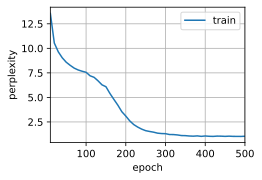

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, num_hiddens, lr, num_epochs, strategy)

Finalmente,
vamos verificar os resultados do uso do método de amostragem aleatória.


perplexity 1.5, 14944.2 tokens/sec on /GPU:0


time traveller came back andfilby s anecdote collapsedthe thing 


traveller came back andfilby s anecdote collapsedthe thing 


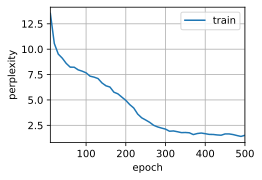

In [17]:
params = get_params(len(vocab_random_iter), num_hiddens)
train_ch8(net, train_random_iter, vocab_random_iter, num_hiddens, lr,
          num_epochs, strategy, use_random_iter=True)

Embora a implementação do modelo RNN acima do zero seja instrutiva, não é conveniente.
Na próxima seção, veremos como melhorar o modelo RNN,
por exemplo, como torná-lo mais fácil de implementar
e fazê-lo funcionar mais rápido.


## Resumo

* Podemos treinar um modelo de linguagem de nível de caractere baseado em RNN para gerar texto seguindo o prefixo de texto fornecido pelo usuário.
* Um modelo de linguagem RNN simples consiste em codificação de entrada, modelagem RNN e geração de saída.
* Os modelos RNN precisam de inicialização de estado para treinamento, embora a amostragem aleatória e o particionamento sequencial usem maneiras diferentes.
* Ao usar o particionamento sequencial, precisamos separar o gradiente para reduzir o custo computacional.
* Um período de aquecimento permite que um modelo se atualize (por exemplo, obtenha um estado oculto melhor do que seu valor inicializado) antes de fazer qualquer previsão.
* O recorte de gradiente evita a explosão do gradiente, mas não pode corrigir gradientes que desaparecem.

## Exercícios

1. Mostre que a codificação one-hot é equivalente a escolher uma incorporação diferente para cada objeto.
1. Ajuste os hiperparâmetros (por exemplo, número de épocas, número de unidades ocultas, número de etapas de tempo em um minibatch e taxa de aprendizado) para melhorar a perplexidade.
    * Quão baixo você pode ir?
    * Substitua a codificação one-hot por *embeddings* que podem ser aprendidos. Isso leva a um melhor desempenho?
    * Será que funcionará bem em outros livros de H. G. Wells, por exemplo, [*The War of the Worlds*](http://www.gutenberg.org/ebooks/36)?
1. Modifique a função de previsão para usar amostragem em vez de escolher o próximo caractere mais provável.
    * O que acontece?
    * Desvie o modelo para resultados mais prováveis, por exemplo, amostrando de $q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$ para $\alpha > 1$.
1. Execute o código nesta seção sem cortar o gradiente. O que acontece?
1. Altere o particionamento sequencial para que não separe os estados ocultos do gráfico computacional. O tempo de execução muda? Que tal a perplexidade?
1. Substitua a função de ativação usada nesta seção por ReLU e repita os experimentos nesta seção. Ainda precisamos de recorte de gradiente? Por quê?


[Discussions](https://discuss.d2l.ai/t/1052)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTkyNjIwNjc1NCwtOTQ5ODEyNjU1LDU4Mz
c5ODE1Miw0NjY5MzgxMTQsLTEwNjczNTI4MzhdfQ==
-->
